In [2]:
import pandas as pd
import numpy as np
import urllib.request

def downDataIntoCleanRows():
    # Download the global confirmed cases CSV file from the John's Hopkins Github repository and save to a clean dataframe
    url = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
    filename = 'time_series_covid19_confirmed_global.csv'     # filename for the file AFTER we save it
    urllib.request.urlretrieve(url, filename)     # command to download the file
    confirmed = cleanCSV(filename)

    # Download the global recovered cases CSV file from the John's Hopkins Github repository and save to a clean dataframe
    url = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
    filename = 'time_series_covid19_recovered_global.csv'
    urllib.request.urlretrieve(url, filename)
    recovered = cleanCSV(filename)

    # Download the global deaths CSV file from the John's Hopkins Github repository and save to a clean dataframe
    url = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
    filename = 'time_series_covid19_deaths_global.csv'
    urllib.request.urlretrieve(url, filename)
    deaths = cleanCSV(filename)

    return confirmed, recovered, deaths

def cleanCSV(filename):
    # Read the CSV file into a Pandas dataframe
    dataFrame = pd.read_csv(filename)

    # Replace slashes with _ in the header (cleaning the data)
    dataFrame.columns = [column.replace('/','_') for column in dataFrame.columns]

    return dataFrame

In [3]:
def queryForCountry(confirmed, recovered, deaths, countryName):
    # Find data from the specified country
    confirmed = confirmed.query('Country_Region == @countryName')
    recovered = recovered.query('Country_Region == @countryName')
    deaths = deaths.query('Country_Region == @countryName')

    # Drop columns that we don't need (for comparison with SIR models)
    confirmed = confirmed.drop(['Province_State', 'Country_Region', 'Lat', 'Long'], axis=1)
    recovered = recovered.drop(['Province_State', 'Country_Region', 'Lat', 'Long'], axis=1)
    deaths = deaths.drop(['Province_State', 'Country_Region', 'Lat', 'Long'], axis=1)

    # Convert these dataframes to NumPy
    confirmed = confirmed.to_numpy()[0]
    recovered = recovered.to_numpy()[0]
    deaths = deaths.to_numpy()[0]

    # Read the CSV file for populations
    populations = pd.read_csv('WorldBankPopulation2018.csv')

    # Drop columns we don't need
    populations = populations.drop(['Country_Code'], axis=1)

    # Query the populations for the country we chose
    populations = populations.query('Country_Name == @countryName')

    # Convert dataframe to NumPy and choose the value in column 1 (population)
    countryPopulation = populations.to_numpy()[0][1]

    R = recovered + deaths
    I = confirmed - R
    S = countryPopulation - confirmed

    firstCase = np.nonzero(I)[0][0] + 10

    S = S[firstCase:]
    I = I[firstCase:]
    R = R[firstCase:]

    data = np.vstack((S,I,R))

    data = np.array(list(data[:,:]), dtype=np.float64)

    return data

In [4]:
# This code block imports all the libraries we need, saves all the functions, and
# reads data from CSV and prepares it for analysis

# IMPORT NECESSARY LIBRARIES
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import optimize


## FUNCTIONS WE HAVE WRITTEN
# Simulate the SIR model if we know alpha, beta, S0, I0, R0
def sirBasic(S0, I0, R0, alpha, beta, n):
    # Make an empty 3 by 101 matrix that will be the predicted number of people in each group
    SIR = np.zeros((3,n+1))

    # fill in the initial data
    SIR[:,0] = np.array([S0, I0, R0])

    for i in range(n):
        SIR[:,i+1] = SIR[:,i] + np.array([-beta*SIR[0,i]*SIR[1,i], beta*SIR[0,i]*SIR[1,i] - alpha*SIR[1,i], alpha*SIR[1,i]])

    return SIR

# Advanced SIR Model
# alpha1 transitions to alpha2 according to a sigmoid curve
# (center of transition at time n1 and k1 controls how fast it transitions)
# beta1 transitions to beta2 according to a sigmoid curve
# (center of transition at time m1 and j1 controls how fast it transitions)

# Sigmoid function
def sigmoid(t):
    return 1/(1+np.exp(-t))

# Advanced SIR simulation
def sirAdvanced(S0, I0, R0, alpha1, alpha2, beta1, beta2, n1, m1, k, j, n):
    # Make an empty 3 by 101 matrix that will be the predicted number of people in each group
    SIR = np.zeros((3,n+1))

    # fill in the initial data
    SIR[:,0] = np.array([S0, I0, R0])

    for i in range(n):
        # update alpha
        alpha = (alpha2 - alpha1)*sigmoid(k*(i - n1)) + alpha1

        # update beta
        beta = (beta2 - beta1)*sigmoid(j*(i - m1)) + beta1

        SIR[:,i+1] = SIR[:,i] + np.array([-beta*SIR[0,i]*SIR[1,i], beta*SIR[0,i]*SIR[1,i] - alpha*SIR[1,i], alpha*SIR[1,i]])

    return SIR

# Function that computes the error between simulated data and real data
def findError(data, simulated):
    return math.sqrt(np.sum((data - simulated)**2))

# Gradient descent method that minimizes a function of one variable
def gradientDescent1D(f, x0, h, tolerance, maxIterations):
    x = x0
    step = h

    for counter in range(maxIterations+1):
        slope = (f(x+step) - f(x))/step
        step = -slope*h
        x = x + step

        if x < 0:
            x = -1*x

        if math.fabs(slope) < tolerance:
            print('1D gradient descent took', counter, 'iterations to converge')
            print('The slope at', x, 'is approximately', slope)
            return x
            break

        if counter == maxIterations:
            print('1D gradient descent failed')
            print('The slope at', x, 'is approximately', slope)
            return x

## DATA PREPARATION AND READING FROM CSV

confirmed, recovered, deaths = downDataIntoCleanRows()
data = queryForCountry(confirmed, recovered, deaths, 'Germany')

# Pull initial data values from the real data
S0 = data[0,0]
I0 = data[1,0]
R0 = data[2,0]

lastDay = data.shape[1] - 1

In [5]:
# this is ERR(alpha,b)
# Basic Model
# x = [x[0], x[1]] = (alpha, b)
f = lambda x: findError(sirBasic(S0,I0,R0,x[0],x[1]/S0,lastDay), data)

# Advanced Model
# x = [x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7]] = (alpha1, alpha2, beta1, beta2, n1, m1, k, j)
#f = lambda x: findError(sirAdvanced(S0,I0,R0,x[0],x[1],x[2]/S0,x[3]/S0,x[4],x[5],x[6],x[7],lastDay), data)

# Run the optimization code (multidimensional gradient descent) to find the best parameters for ths model
# to fit to the data. (This solves for *all* parameters at one time!)

result = optimize.minimize(f, [0.01, 0.01], bounds = ((0,1), (0,1)))
#result = optimize.minimize(f, [0.1, 0.2, 0.3, 0.5, lastDay/2, lastDay/2, 1, 1],
#                           bounds=((0.1,1),(0.1,1),(0.01,1),(0.01,1),(0,lastDay),(0,lastDay),(0,5),(0,5)))

print(result)

x = result.x

      fun: 1591552.6664015974
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 7.76955854e+01, -1.26109295e+05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 177
      nit: 20
     njev: 59
   status: 0
  success: True
        x: array([0.95200894, 1.        ])


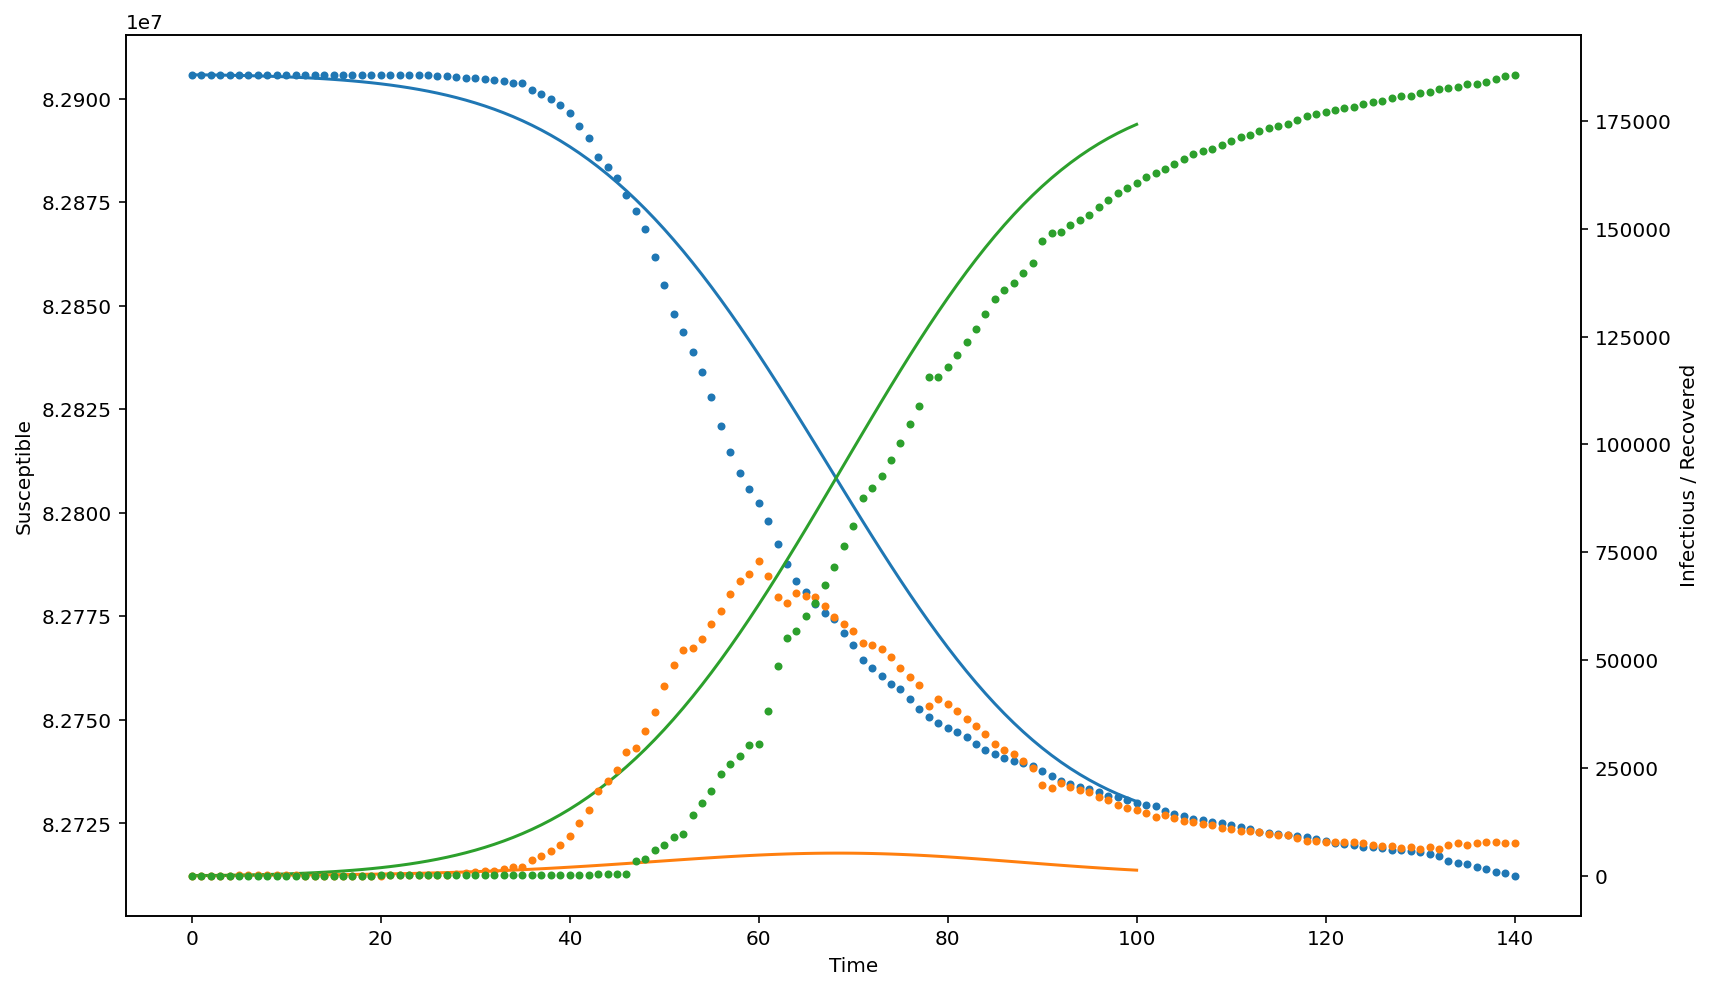

In [5]:
n = 100
#simulated = sirBasic(S0,I0,R0,x[0],x[1]/S0,n)
simulated = sirAdvanced(S0,I0,R0,x[0],x[1],x[2]/S0,x[3]/S0,x[4],x[5],x[6],x[7],n)

fig, ax1 = plt.subplots()

ax1.set_xlabel('Time')
ax1.set_ylabel('Susceptible')
ax1.plot(simulated[0,:],color='tab:blue',label='Susceptible')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('Infectious / Recovered')  # we already handled the x-label with ax1
ax2.plot(simulated[1,:],color='tab:orange',label='Infectious')
ax2.plot(simulated[2,:],color='tab:green',label='Recovered')
ax2.tick_params(axis='y')

ax1.plot(data[0,:],'.',label='S data',color='tab:blue')
ax2.plot(data[1,:],'.',label='I data',color='tab:orange')
ax2.plot(data[2,:],'.',label='R data',color='tab:green')

ax1.ticklabel_format(useOffset=False)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
#plt.legend()

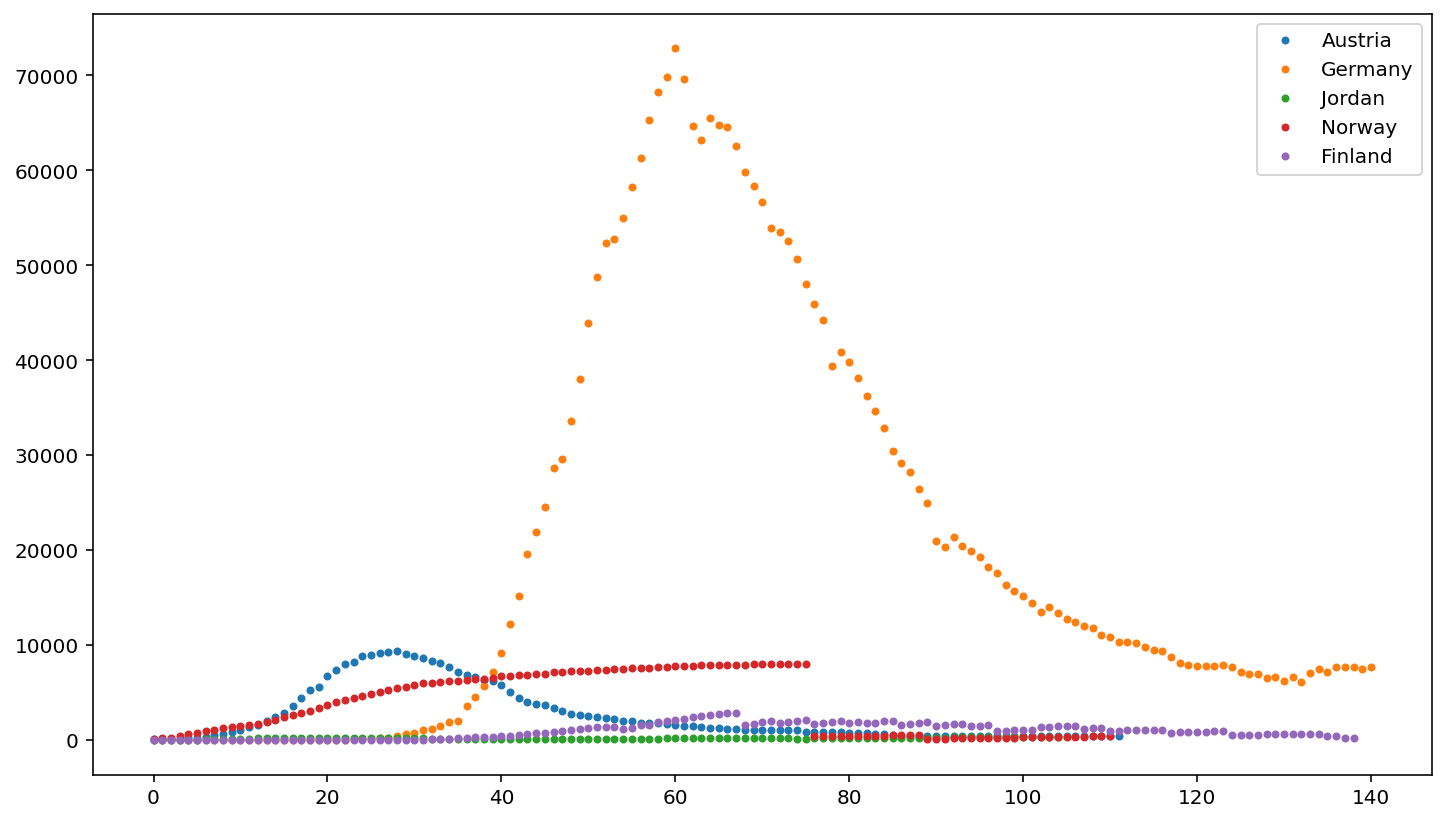

In [9]:
Countries = ['Austria', 'Germany', 'Jordan', 'Norway', 'Finland']
for countryName in Countries:
    confirmed, recovered, deaths = downDataIntoCleanRows()
    data = queryForCountry(confirmed, recovered, deaths, countryName)
    plt.plot(data[1,:],'.',label=countryName)
plt.legend()